## AMM Optimization, 1st model

In [1]:
using Gurobi, JuMP, CSV, Tables, Ipopt, Plots

In [2]:
# With an order amount of token x
function optimize_market_impact(liquidity, order_amount)

    amount_token_x_per_pool = liquidity[:, 1] 
    amount_token_y_per_pool = liquidity[:, 2]

    # Create a new model
    model = Model(Ipopt.Optimizer)

    # Create variables
    @variable(model, x[1:size(liquidity,1)] >= 0)

    # Set objective
    @NLobjective(model, Min, sum((amount_token_y_per_pool[i]*x[i]*(2*amount_token_x_per_pool[i] - x[i]) )/(x[i]*(amount_token_x_per_pool[i]- x[i])^2) for i in 1:size(liquidity,1)))

    # Add constraint
    @constraint(model, sum(x) == order_amount)
    @constraint(model, x .<= amount_token_x_per_pool)

    # Optimize model
    optimize!(model)

    # Return the optimal solution
    return value.(x)
end

optimize_market_impact (generic function with 1 method)

In [119]:
# With an order amount of token x
function optimize_price_paid(liquidity, order_amount)

    amount_token_x_per_pool = liquidity[:, 1] 
    amount_token_y_per_pool = liquidity[:, 2]

    # Create a new model
    model = Model(Ipopt.Optimizer)

    # Create variables
    @variable(model, x[1:size(liquidity,1)])

    # Set objective
    @NLobjective(model, Min, sum((amount_token_y_per_pool[i] * x[i])/ (amount_token_x_per_pool[i]- x[i]) for i in 1:size(liquidity,1)))

    # Add constraint
    @constraint(model, sum(x) == order_amount)
    @constraint(model, x .<= amount_token_x_per_pool)

    # Optimize model
    optimize!(model)

    # Return the optimal solution
    return value.(x)
end

optimize_price_paid (generic function with 1 method)

## EXPERIMENT 1: AMM Optimization, no transaction costs

### Generating random data

We just need to preserve the current magnitude. Also AMMs need to be close to each other in the absence of transaction costs.

In [4]:
ETH_USDT = 1210;

In [5]:
ETH = rand(3000:3500, 6)
USD = ETH .* ETH_USDT
liquidity = [ETH USD];

In [6]:
amount_token_x_per_pool = liquidity[:, 1]
amount_token_y_per_pool = liquidity[:, 2]

model = Model(Gurobi.Optimizer)

#@variable(model, 0 <= x[1:length(liquidity)] <= amount_token_x_per_pool[1:length(liquidity)])
size(liquidity,1)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18


6

In [7]:
liquidity

6×2 Matrix{Int64}:
 3136  3794560
 3311  4006310
 3090  3738900
 3004  3634840
 3175  3841750
 3362  4068020

In [9]:
liquidity_invariants = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    liquidity_invariants[i] = liquidity[i,1] * liquidity[i,2]
end

### Plotting the data and different pools

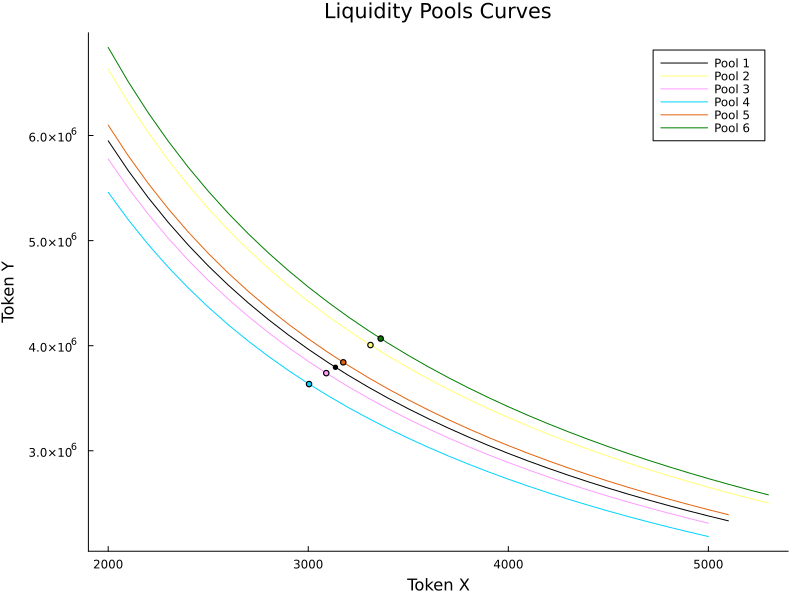

In [18]:
# reset the plot
plot()

# give me size(liquidity,1) different colors 
colors = distinguishable_colors(size(liquidity,1))

 # Plot the liquidity pools curves for the pools
for i in 1:size(liquidity,1)
    plot!(2000:100:liquidity[i,1] + 2000, x -> liquidity_invariants[i]/x, label="Pool $i", color=colors[i])
    #Add the pool points same coloration as the curve
    scatter!([liquidity[i,1]], [liquidity[i,2]], label="", color=colors[i], markersize=3)
end

# show the plot and legend top right
plot!(xlabel="Token X", ylabel="Token Y", legend=:topright, title="Liquidity Pools Curves", size=(800, 600), grid=false)

## First experiment: optimization of the market impact

We want to split our large trade into many single trades, such that we minimize the market impact, meaning that the influence of our trade on each AMM is the lowest possible

In [ ]:
split_trades = optimize_market_impact(liquidity, 1000)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4520068e+04 1.00e+03 3.81e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

6-element Vector{Float64}:
 235.91642860660855
 233.00193453964343
  83.0707488420638
 191.28945655009082
 132.55548488769108
 124.16594657390236

### If we have pools with exactly the same magnitude, we have:

In [ ]:
ETH_USDT = 1210;
ETH = rand(3000:3000, 12)
USD = ETH .* ETH_USDT
liquidity = [ETH USD];

amount_token_x_per_pool = liquidity[:, 1]
amount_token_y_per_pool = liquidity[:, 2]

split_trades = optimize_market_impact(liquidity, 1000) 

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:       12
                     variables with only lower bounds:       12
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9040145e+04 1.00e+03 1.11e-16  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

12-element Vector{Float64}:
 83.33333333333633
 83.33333333333727
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266
 83.33333333333266

As expected, we split the order into 12 trades, each of 1000/12 = 83.33 ETH. The total amount of ETH we get is 1000, as expected.

 Now we study what happens when we have pools with different magnitudes. We can do the analysis on the sorted list of pools as it does not change anything. and will be easier to interpret

In [84]:
ETH_USDT = 1210;
# arrange for ETH
ETH = rand(2500:3500, 6)
ETH = sort(ETH, rev=false)
USD = ETH .* ETH_USDT
liquidity = [ETH USD];

println("ETH amount", liquidity[:, 1])
println("USDT amount", liquidity[:, 2])
order_amount = 3000
println("Order amount", order_amount)

split_trades = optimize_market_impact(liquidity, order_amount)

ETH amount[2561, 2714, 2897, 2901, 2910, 3069]
USDT amount[3098810, 3283940, 3505370, 3510210, 3521100, 3713490]
Order amount3000
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

iter    objective    inf_pr  

6-element Vector{Float64}:
 366.9184883348878
 438.23347408130564
 525.6369327927005
 527.5715927251102
 531.9282454661161
 609.71126659988

#### Plots, pools with different magnitudes

Variation of liquidity in the pools before and after the trade

In [85]:
liquidity_invariants = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    liquidity_invariants[i] = liquidity[i,1] * liquidity[i,2]
end

delta_token_x = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    delta_token_x[i] = liquidity[i,1] - split_trades[i]
end

delta_token_y = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    delta_token_y[i] = liquidity[i,2] + (liquidity[i,2]*split_trades[i]/(liquidity[i,1] - split_trades[i]))
end

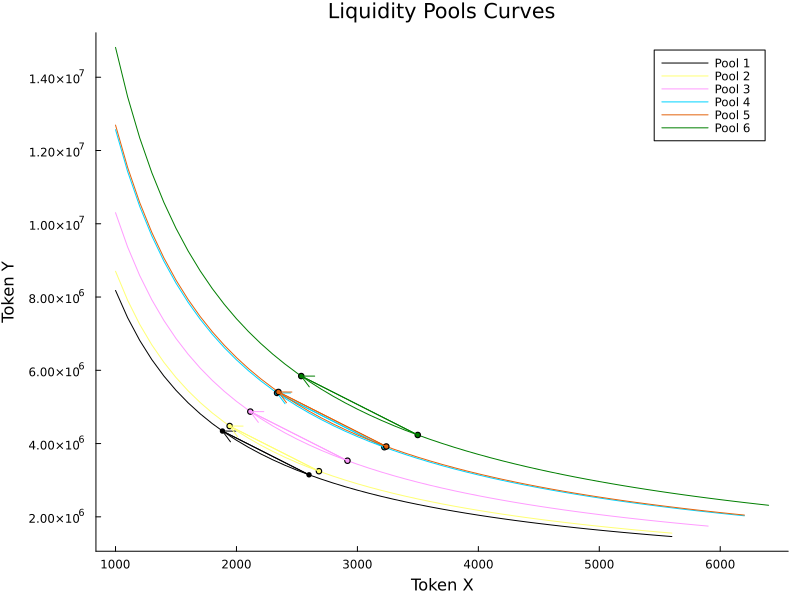

In [112]:
# reset the plot
plot()

# give me size(liquidity,1) different colors 
colors = distinguishable_colors(size(liquidity,1))

 # Plot the liquidity pools curves for the pools
for i in 1:size(liquidity,1)
    plot!(1000:100:liquidity[i,1] + 3000, x -> liquidity_invariants[i]/x, label="Pool $i", color=colors[i])
    #Add the pool points same coloration as the curve
    scatter!([liquidity[i,1]], [liquidity[i,2]], label="", color=colors[i], markersize=3)
    #Add the pool points same coloration as the curve
    scatter!([delta_token_x[i]], [delta_token_y[i]], label="", color=colors[i], markersize=3)
    # Add arrows to show the trade
    plot!([liquidity[i,1], delta_token_x[i]], [liquidity[i,2], delta_token_y[i]], label="", color=colors[i], arrow=true)
end

#plot!([liquidity[:,1]; delta_token_x], [liquidity[:,2]; delta_token_y], label="")

# show the plot and legend top right
plot!(xlabel="Token X", ylabel="Token Y", legend=:topright, title="Liquidity Pools Curves", size=(800, 600), grid=false)

We can now compare that with the price we would have gotten if we had used the pool with the highest magnitude.

##### Price paid analysis

Here I want to get 1000 ETH, what will be my execution price?

\begin{gather*}
    (x_{eth} - \Delta x_{eth}) (y_{usd} + \Delta y_{usd}) = x_{eth}y_{usd} \\
    \Delta y_{usd} = \frac{y_{usd} \Delta x_{eth}}{x_{eth} - \Delta x_{eth}} \\    
\end{gather*}

Where $x_{eth}$ and $y_{usd}$ are the current balances of the pool ($liq_{i, 1}$ and $liq_{i, 2}$)

Finally, the order execution price one AMM is:

\begin{gather*}
    p_{exec} = \frac{\Delta y_{usd}}{\Delta x_{eth}} = \frac{y_{usd}}{x_{eth} - \Delta x_{eth}}
\end{gather*}

If we split the order over all the AMMs, the overall execution price would be

\begin{gather*}
    p_{exec} = \sum_{i=1}^{n} \frac{y_{i, usd}}{x_{i, eth} - \Delta x_{i, eth}} * \frac{\Delta x_{i, eth}}{order\_size}
\end{gather*}


In [87]:
price = sum((split_trades[i]/order_amount)*liquidity[i, 2] / (liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)) 
price_exec_baseline_pool = [liquidity[i, 2] / (liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]
avg_split = [order_amount / size(liquidity,1) for i in 1:size(liquidity,1)]
price_avg_amm = sum((avg_split[i]/order_amount)*liquidity[i, 2] / (liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1))
println("Price with split trades: ", price)
println("Price without split trades: ", price_exec_baseline_pool)
println("Price with even split on all Amms: ", price_avg_amm)


Price with split trades: 1472.0352201884625
Price without split trades: [-7058.7927107061505, -11482.307692307691, -34032.71844660194, -35456.666666666664, -39123.333333333336, 53818.69565217391]
Price with even split on all Amms: 1469.6204335220366


We see here that our average buying price is actualy higer that the price we would have gotten if we had splitted the order equally over the different AMMs.

##### Market impact analysis

The optimization model that we ran was optimizing the trades to minimize the market impact. That said, we want to evaluate, what is the price post trade in each pool.
It is given by the following formula : 

\begin{gather*}
    p_{post} = \frac{y_{i, usd} + \Delta y_{i, usd}}{x_{i, eth} - \Delta x_{i, eth}}
\end{gather*}

In [88]:
del_y = [liquidity[i, 2]*split_trades[i]/(liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)]
price_post_trade_per_pool = [(liquidity[i, 2] + del_y[i])/ (liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)]

# Comparison with an average split
avg_split = [order_amount / size(liquidity,1) for i in 1:size(liquidity,1)]
del_y_avg = [liquidity[i, 2]*avg_split[i]/(liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1)]
price_post_trade_per_pool_avg = [(liquidity[i, 2] + del_y_avg[i])/ (liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1)]

# Comparison with doing the trade on a single pool (each element in the array is "if we did the trade on this pool")
del_y_pool = [liquidity[i, 2]*order_amount/(liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]
price_post_trade_per_pool_pool = [(liquidity[i, 2] + del_y_pool[i])/ (liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]

println("Simulated price after trade per pool: ", price_post_trade_per_pool)
println("Simulated price after trade per pool if we had done an average split: ", price_post_trade_per_pool_avg)
println("Simulated price after trade per pool if we had done the trade on a single pool (displayed for all the pools): ", price_post_trade_per_pool_pool)

Simulated price after trade per pool: [1648.538186339945, 1720.8762730814906, 1805.8690604657047, 1807.7091478737887, 1811.8466570867574, 1884.3436427611737]
Simulated price after trade per pool if we had done an average split: [1868.3083022637315, 1818.2342064010825, 1767.4465648463026, 1766.4303086958248, 1764.1571253938466, 1726.83538237218]
Simulated price after trade per pool if we had done the trade on a single pool (displayed for all the pools): [41178.97068819693, 108961.47928994083, 957211.5081534546, 1.0389877777777778e6, 1.2649877777777778e6, 2.3937619848771268e6]


## Second experiment: optimization of the execution price

We don't care anymore of the market impact, we just want to minimize the execution price. 
Nb: This approach is a simulation and we shouldn't actually do that in real life, because the markets are correlated, and we don't model time here. SO if we have a big market impact on one AMM, there would be arbitrageurs that would take advantage of that.

In [102]:
ETH_USDT = 1210;
# arrange for ETH
ETH = rand(2500:3500, 6)
ETH = sort(ETH, rev=false)
USD = ETH .* ETH_USDT
liquidity = [ETH USD];

println("ETH amount ", liquidity[:, 1])
println("USDT amount ", liquidity[:, 2])
order_amount = 5000
println("Order amount ", order_amount)

split_trades = optimize_price_paid(liquidity, order_amount)

ETH amount [2600, 2682, 2918, 3223, 3239, 3499]
USDT amount [3146000, 3245220, 3530780, 3899830, 3919190, 4233790]
Order amount 5000
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

iter    objective    inf_p

6-element Vector{Float64}:
 715.8196134574102
 738.3954628049129
 803.369858487969
 887.3410054512409
 891.7460492263635
 963.3280105721034

In [103]:
liquidity_invariants = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    liquidity_invariants[i] = liquidity[i,1] * liquidity[i,2]
end

delta_token_x = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    delta_token_x[i] = liquidity[i,1] - split_trades[i]
end

delta_token_y = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    delta_token_y[i] = liquidity[i,2] + (liquidity[i,2]*split_trades[i]/(liquidity[i,1] - split_trades[i]))
end

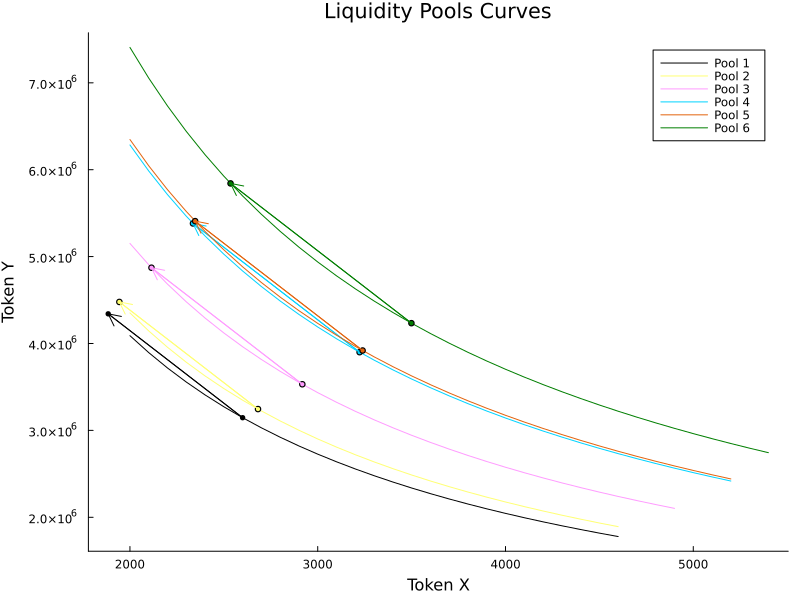

In [104]:
# reset the plot
plot()

# give me size(liquidity,1) different colors 
colors = distinguishable_colors(size(liquidity,1))

 # Plot the liquidity pools curves for the pools
for i in 1:size(liquidity,1)
    plot!(2000:100:liquidity[i,1] + 2000, x -> liquidity_invariants[i]/x, label="Pool $i", color=colors[i])
    #Add the pool points same coloration as the curve
    scatter!([liquidity[i,1]], [liquidity[i,2]], label="", color=colors[i], markersize=3)
    #Add the pool points same coloration as the curve
    scatter!([delta_token_x[i]], [delta_token_y[i]], label="", color=colors[i], markersize=3)
    # Add arrows to show the trade
    plot!([liquidity[i,1], delta_token_x[i]], [liquidity[i,2], delta_token_y[i]], label="", color=colors[i], arrow=true)
end

# show the plot and legend top right
plot!(xlabel="Token X", ylabel="Token Y", legend=:topright, title="Liquidity Pools Curves", size=(800, 600), grid=false)

In [105]:
price = sum((split_trades[i]/order_amount)*liquidity[i, 2] / (liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)) 
price_exec_baseline_pool = [liquidity[i, 2] / (liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]
avg_split = [order_amount / size(liquidity,1) for i in 1:size(liquidity,1)]
price_avg_amm = sum((avg_split[i]/order_amount)*liquidity[i, 2] / (liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1))
println("Price with split trades: ", price)
println("Price without split trades: ", price_exec_baseline_pool)
println("Price with even split on all Amms: ", price_avg_amm)

Price with split trades: 1669.6915128029784
Price without split trades: [-1310.8333333333333, -1400.0086281276963, -1695.8597502401537, -2194.6145188519977, -2225.5479840999433, -2820.6462358427716]
Price with even split on all Amms: 1679.8758386875252


In [106]:
del_y = [liquidity[i, 2]*split_trades[i]/(liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)]
price_post_trade_per_pool = [(liquidity[i, 2] + del_y[i])/ (liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)]

# Comparison with an average split
avg_split = [order_amount / size(liquidity,1) for i in 1:size(liquidity,1)]
del_y_avg = [liquidity[i, 2]*avg_split[i]/(liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1)]
price_post_trade_per_pool_avg = [(liquidity[i, 2] + del_y_avg[i])/ (liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1)]

# Comparison with doing the trade on a single pool (each element in the array is "if we did the trade on this pool")
del_y_pool = [liquidity[i, 2]*order_amount/(liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]
price_post_trade_per_pool_pool = [(liquidity[i, 2] + del_y_pool[i])/ (liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]

println("Simulated price after trade per pool: ", price_post_trade_per_pool)
println("Simulated price after trade per pool if we had done an average split: ", price_post_trade_per_pool_avg)
println("Simulated price after trade per pool if we had done the trade on a single pool (displayed for all the pools): ", price_post_trade_per_pool_pool)

Simulated price after trade per pool: [2304.0245850630604, 2304.02458506306, 2304.024585063057, 2304.024585063056, 2304.024585063056, 2304.0245850630536]
Simulated price after trade per pool if we had done an average split: [2620.733357066572, 2546.7463728922803, 2370.7333059320454, 2201.057205450203, 2193.493567612028, 2084.7864355598276]
Simulated price after trade per pool if we had done the trade on a single pool (displayed for all the pools): [1420.0694444444446, 1619.8546767206565, 2376.8101590781794, 3980.4404019470953, 4093.4411814308437, 6575.243956838013]


Noticeably, the problem converges towards a solution where we split the order such that the price after trade is the same for all the AMMs.

## Third experiment: optimization of the execution price on pools with different prices

In [149]:
ETH_USDT = rand(1150:1250, 6)
# arrange for ETH
ETH = rand(2500:3500, 6)
ETH = sort(ETH, rev=false)
USD = [ETH[i] * ETH_USDT[i] for i in 1:size(ETH,1)]
liquidity = [ETH USD];

println("ETH amount ", liquidity[:, 1])
println("USDT amount ", liquidity[:, 2])
order_amount = 100
println("Order amount ", order_amount)

split_trades = optimize_price_paid(liquidity, order_amount)

ETH amount [2537, 2587, 2843, 2973, 3037, 3412]
USDT amount [3130658, 3161314, 3397385, 3549762, 3583660, 4032984]
Order amount 100
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

iter    objective    inf_pr

6-element Vector{Float64}:
 -21.6564804388867
  -9.366320868863957
  21.404541466308963
  23.618118968476786
  41.84204319781235
  44.15809767515256

In [150]:
liquidity_invariants = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    liquidity_invariants[i] = liquidity[i,1] * liquidity[i,2]
end

delta_token_x = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    delta_token_x[i] = liquidity[i,1] - split_trades[i]
end

delta_token_y = zeros(size(liquidity,1))
for i in 1:size(liquidity,1)
    delta_token_y[i] = liquidity[i,2] + (liquidity[i,2]*split_trades[i]/(liquidity[i,1] - split_trades[i]))
end

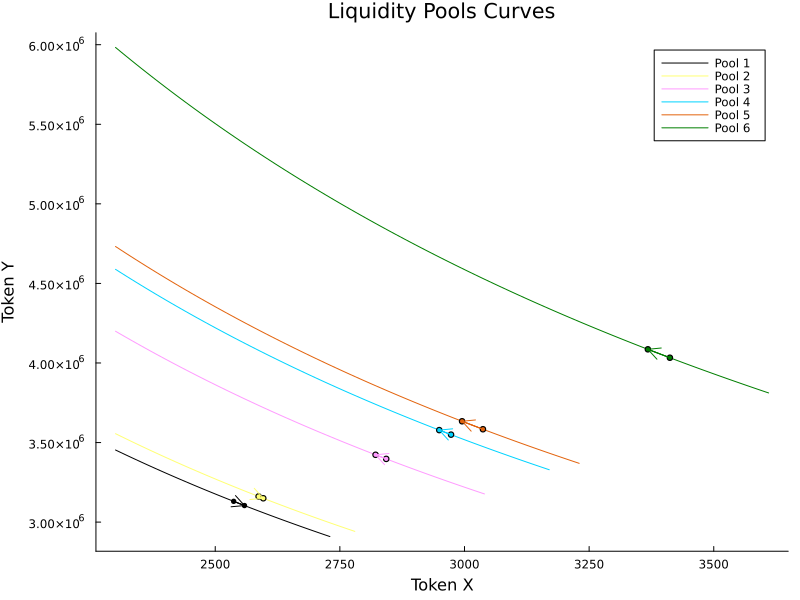

In [151]:
# reset the plot
plot()

# give me size(liquidity,1) different colors 
colors = distinguishable_colors(size(liquidity,1))


 # Plot the liquidity pools curves for the pools
for i in 1:size(liquidity,1)
    plot!(2300:10:liquidity[i,1] + 200, x -> liquidity_invariants[i]/x, label="Pool $i", color=colors[i])
    #Add the pool points same coloration as the curve
    scatter!([liquidity[i,1]], [liquidity[i,2]], label="", color=colors[i], markersize=3)
    #Add the pool points same coloration as the curve
    scatter!([delta_token_x[i]], [delta_token_y[i]], label="", color=colors[i], markersize=3)
    # Add arrows to show the trade
    plot!([liquidity[i,1], delta_token_x[i]], [liquidity[i,2], delta_token_y[i]], label="", color=colors[i], arrow=true)
end

# show the plot and legend top right
plot!(xlabel="Token X", ylabel="Token Y", legend=:topright, title="Liquidity Pools Curves", size=(800, 600), grid=false)